## Introduction

We are exploring two different questions:
1. What attributes are involved with schools that have CS programs vs schools that do not? This question will be tackled first.
2. For schools with CS, do any attributes of the individual student contribute to whether or not they take CS? This may be explored in a separate notebook. And the enrollment rate?

In [53]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
ospi_data = pd.read_csv('2022_school_pt5.csv',  index_col=0)

In [4]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,57,16,18,9,15,2,14,1,13,5
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,107,14,32,5,35,3,25,3,21,7
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,142,0,16,0,51,0,41,0,59,0


In [5]:
ospi_data.isna().sum()

DistrictCode       0
SchoolCode         0
SchoolName         0
Longitude          0
Latitude           0
County             0
AllStudents        0
C_AllStudents      0
G_Female           0
GC_Female          0
G_Male             0
GC_Male            0
G_GenderX          0
GC_GenderX         0
R_Native           0
RC_Native          0
R_Asian            0
RC_Asian           0
R_Black            0
RC_Black           0
R_Hisp_Lat         0
RC_Hisp_Lat        0
R_HPI              0
RC_HPI             0
R_NA               0
RC_NA              0
R_TwoOrMore        0
RC_TwoOrMore       0
R_White            0
RC_White           0
L_ELL              0
LC_ELL             0
L_NoELL            0
LC_NoELL           0
I_LowIncome        0
IC_LowIncome       0
I_NoLowIncome      0
IC_NoLowIncome     0
D_Disability       0
DC_Disability      0
D_NoDisability     0
DC_NoDisability    0
A_9                0
AC_9               0
A_10               0
AC_10              0
A_11               0
AC_11        

In [6]:
len(ospi_data.index)

730

In [7]:
ospi_data['AllStudents'].sum()

390223

In [8]:
ospi_data = ospi_data.iloc[:,:-15]

In [9]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,0,2,0,24,3,0,0,28,3,17
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,0,3,0,98,17,402,54,879,115,1069
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,0,4,2,32,5,7,3,53,14,48
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,0,3,0,97,16,0,0,113,18,47
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,0,5,0,148,0,0,0,167,0,133


In [10]:
def low_inc_perc(row):
    return row['I_LowIncome'] / row['AllStudents']

ospi_data['PercentLowIncome'] = ospi_data.apply(low_inc_perc, axis=1)

In [11]:
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,...,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,...,2,0,24,3,0,0,28,3,17,0.607143
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,...,3,0,98,17,402,54,879,115,1069,0.834504
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,...,4,2,32,5,7,3,53,14,48,0.800000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,...,3,0,97,16,0,0,113,18,47,0.415929
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,...,5,0,148,0,0,0,167,0,133,0.796407


In [12]:
pd.set_option('display.max_columns', None)
ospi_data.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,0.607143
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,0.834504
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,30,8,29,9,1,0,0,0,0,0,1,0,23,10,0,0,0,0,4,2,32,5,7,3,53,14,48,0.800000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,57,9,56,9,0,0,2,2,2,0,0,0,9,0,0,0,0,0,3,0,97,16,0,0,113,18,47,0.415929
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,89,0,78,0,0,0,1,0,0,0,2,0,11,0,0,0,0,0,5,0,148,0,0,0,167,0,133,0.796407


For the following, note that BIPOC does not include Asian in this calculation. The following calculation includes all reported racial identities except for Asian and white.

In [13]:
def number_bipoc(row):
    return (row['R_Native'] + row['R_Black'] + row['R_Hisp_Lat'] + row['R_HPI'] + row['R_TwoOrMore'])

ospi_data['R_BIPOC'] = ospi_data.apply(number_bipoc, axis=1)

In [14]:
def bipoc_perc(row):
    return (row['R_BIPOC']) / row['AllStudents']

ospi_data['PercentBIPOC'] = ospi_data.apply(bipoc_perc, axis=1)

## Preprocessing: Percentage of District Low Income and BIPOC

In [15]:
ospi_data['DistrictNumSchools'] = ospi_data.groupby('DistrictCode')['SchoolCode'].transform('size')
ospi_data['DistrictSize'] = ospi_data.groupby('DistrictCode')['AllStudents'].transform('sum')
ospi_data['DistrictLowIncome'] = ospi_data.groupby('DistrictCode')['I_LowIncome'].transform('sum')
ospi_data['DistrictPctLowIncome'] = ospi_data['DistrictLowIncome']/ospi_data['DistrictSize']
ospi_data['DistrictBIPOC'] = ospi_data.groupby('DistrictCode')['R_BIPOC'].transform('sum')
ospi_data['DistrictPctBIPOC'] = ospi_data['DistrictBIPOC']/ospi_data['DistrictSize']

In [16]:
columns_to_analyze = ['DistrictCode','SchoolCode','SchoolName','Longitude'
                      ,'Latitude','County','AllStudents','C_AllStudents', 'I_LowIncome', 'PercentLowIncome'
                      , 'R_BIPOC' ,'PercentBIPOC','DistrictNumSchools','DistrictSize','DistrictLowIncome','DistrictPctLowIncome'
                      ,'DistrictBIPOC','DistrictPctBIPOC']

reduced_ospi = ospi_data[columns_to_analyze]

In [17]:
reduced_ospi.head(25)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183


Quick sanity check of percentages validity:

In [18]:
reduced_ospi[reduced_ospi['DistrictCode'] == 1147]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399
595,1147,5367,Desert Oasis High School,-119.163036,46.818533,Adams,142,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399
696,1147,5634,Open Door Re-Engagement,-119.173990,46.815949,Adams,41,0,35,0.853659,38,0.926829,3,1464,1235,0.843579,1346,0.919399


In [19]:
ospi_data[ospi_data['DistrictCode'] == 1147]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399
595,1147,5367,Desert Oasis High School,-119.163036,46.818533,Adams,142,0,63,0,79,0,0,0,0,0,0,0,0,0,130,0,0,0,0,0,0,0,12,0,57,0,85,0,131,0.922535,130,0.915493,3,1464,1235,0.843579,1346,0.919399
696,1147,5634,Open Door Re-Engagement,-119.173990,46.815949,Adams,41,0,15,0,26,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,3,0,6,0,35,0,35,0.853659,38,0.926829,3,1464,1235,0.843579,1346,0.919399


## Preprocessing: Hot One Encoding
*Hot one encoding whether or not a school offers CS*  

In [20]:
reduced_ospi = reduced_ospi.copy()
reduced_ospi['CS_Offered'] = np.where(reduced_ospi['C_AllStudents'] == 0, 0, 1)
reduced_ospi.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0


## Preprocessing: Percentage of District with CS

In [21]:
reduced_ospi['DistrictCS'] = reduced_ospi.groupby('DistrictCode')['CS_Offered'].transform('sum')
reduced_ospi['DistrictPctCS'] = reduced_ospi['DistrictCS']/reduced_ospi['DistrictNumSchools']
reduced_ospi.head(25)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.500000
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.500000
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893,0,0,0.000000
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183,0,4,0.500000
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000


Quick sanity check for DistrictPctCS:

In [22]:
reduced_ospi[reduced_ospi['DistrictCode'] == 2250]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.5
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.5
616,2250,5413,Educational Opportunity Center Reengagement,-117.057521,46.411019,Asotin,10,0,7,0.700000,2,0.200000,4,1034,559,0.540619,192,0.185687,0,2,0.5
701,2250,5644,Clarkston Home Alliance,-117.225934,46.369711,Asotin,54,4,30,0.555556,8,0.148148,4,1034,559,0.540619,192,0.185687,1,2,0.5


In [23]:
reduced_ospi[reduced_ospi['DistrictCode'] == 3116]

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS
15,3116,2508,Prosser High School,-119.767241,46.203649,Benton,972,2,683,0.702675,650,0.668724,2,1011,716,0.70821,676,0.668645,1,1,0.5
658,3116,5537,Prosser Opportunity Academy,-119.767241,46.203649,Benton,39,0,33,0.846154,26,0.666667,2,1011,716,0.70821,676,0.668645,0,1,0.5


## Preprocessing: Adding County Population

In [41]:
census_df = pd.read_csv('co-est2023-alldata.csv',  index_col=0, encoding = 'latin')
wa_counties = census_df.loc[census_df['STNAME'] == 'Washington'].copy(deep=True)
wa_pop = wa_counties.loc[:, ('POPESTIMATE2023', 'CTYNAME')]
wa_pop = wa_pop[((wa_pop.CTYNAME != 'Washington'))].copy(deep=True)

In [42]:
def remove_county(row):
    return row['CTYNAME'][:-7]

wa_pop['County'] = wa_pop.apply(remove_county, axis=1)

In [43]:
wa_pop = wa_pop.loc[:, ('POPESTIMATE2023', 'County')]
school_with_pop = pd.merge(wa_pop, reduced_ospi, how='outer', on='County')

In [44]:
reduced_ospi.head()

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS,income_binned,size_binned,bipoc_binned
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000,4,1,1
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333,5,4,5
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000,4,1,3
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000,3,2,1
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.500000,4,2,1


## Preprocessing: Using Longitude and Latitude

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
geo_df_scaled = scaler.fit_transform(reduced_ospi[['Longitude', 'Latitude']])


In [85]:
from sklearn.cluster import KMeans

# Set the number of zones--starting with five for now
num_clusters = 10 
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
reduced_ospi['Zone'] = kmeans.fit_predict(geo_df_scaled)


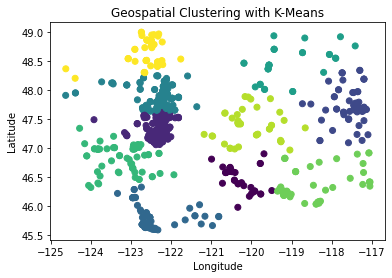

In [86]:
import matplotlib.pyplot as plt

plt.scatter(reduced_ospi['Longitude'], reduced_ospi['Latitude'], c=reduced_ospi['Zone'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Clustering with K-Means')
plt.show()


This did not improve the random forest accuracy.

## Preprocessing: Binning

*Random forest and gradient boosting machines will benefit from binning.*

(School income from original), Bands:  <20%, 20 – 40%, 40% - 60%, 60% - 80%, 80%+

(School size modified from original): <=100, 101 – 300, 301 – 900. 901 – 1800. 1801+

(Disadvantaged race/ethnic percentage): < 15%, 15% - 30%, 30% - 50%, 50% - 75%, 75%+

(Location):  (King),  (Pierce, Snohomish, Spokane, Clark), (All Others). 

In [121]:
income_bins = [-float('inf'), .20, .40, .60, .80, float('inf')]
income_labels = ['1', '2', '3', '4', '5']

size_bins = [-float('inf'), 100, 300, 900, 1800, float('inf')]
size_labels = ['1', '2', '3', '4', '5']

bipoc_bins = [-float('inf'), .15, .30, .50, .75, float('inf')]
bipoc_labels = ['1', '2', '3', '4', '5']

reduced_ospi['IncomeBinned'] = pd.cut(ospi_data['PercentLowIncome'], bins=income_bins, labels=income_labels)
reduced_ospi['SchoolSizeBinned'] = pd.cut(ospi_data['AllStudents'], bins=size_bins, labels=size_labels)
reduced_ospi['BIPOCBinned'] = pd.cut(ospi_data['PercentBIPOC'], bins=bipoc_bins, labels=bipoc_labels)

In [122]:
reduced_ospi['IncomeBinned'].value_counts()

3    225
4    197
2    170
5     73
1     65
Name: IncomeBinned, dtype: int64

In [123]:
reduced_ospi['SchoolSizeBinned'].value_counts()

1    253
2    176
4    125
3    124
5     52
Name: SchoolSizeBinned, dtype: int64

In [124]:
reduced_ospi['BIPOCBinned'].value_counts()

3    247
2    236
4    131
5     60
1     56
Name: BIPOCBinned, dtype: int64

In [125]:
reduced_ospi.head(50)

,DistrictCode,SchoolCode,SchoolName,Longitude,Latitude,County,AllStudents,C_AllStudents,I_LowIncome,PercentLowIncome,R_BIPOC,PercentBIPOC,DistrictNumSchools,DistrictSize,DistrictLowIncome,DistrictPctLowIncome,DistrictBIPOC,DistrictPctBIPOC,CS_Offered,DistrictCS,DistrictPctCS,income_binned,size_binned,bipoc_binned,cluster,Zone,school_size_binned,IncomeBinned,SchoolSizeBinned,BIPOCBinned
0,1109,3075,Washtucna Elementary/High School,-118.311231,46.752189,Adams,28,3,17,0.607143,4,0.142857,1,28,17,0.607143,4,0.142857,1,1,1.000000,4,1,1,4,7,1,4,1,1
1,1147,3015,Othello High School,-119.165246,46.822710,Adams,1281,169,1069,0.834504,1178,0.919594,3,1464,1235,0.843579,1346,0.919399,1,1,0.333333,5,4,5,4,7,4,5,4,5
2,1158,2903,Lind-Ritzville High School,-118.292516,47.125588,Adams,60,17,48,0.800000,28,0.466667,1,60,48,0.800000,28,0.466667,1,1,1.000000,4,1,3,4,2,1,4,1,3
3,1160,2132,Ritzville High School,-118.292516,47.125588,Adams,113,18,47,0.415929,14,0.123894,1,113,47,0.415929,14,0.123894,1,1,1.000000,3,2,1,4,2,2,3,2,1
4,2250,1617,Educational Opportunity Center,-117.057521,46.411019,Asotin,167,0,133,0.796407,19,0.113772,4,1034,559,0.540619,192,0.185687,0,2,0.500000,4,2,1,4,7,2,4,2,1
5,2250,2299,Charles Francis Adams High School,-117.044772,46.410724,Asotin,803,29,389,0.484433,163,0.202989,4,1034,559,0.540619,192,0.185687,1,2,0.500000,3,3,2,4,7,3,3,3,2
6,2420,2434,Asotin Jr Sr High,-117.048210,46.339330,Asotin,177,0,62,0.350282,26,0.146893,1,177,62,0.350282,26,0.146893,0,0,0.000000,2,2,1,4,7,2,2,2,1
7,3017,1884,Legacy High School,-119.184062,46.199694,Benton,716,0,334,0.466480,391,0.546089,8,7166,3615,0.504466,3355,0.468183,0,4,0.500000,3,3,4,4,7,3,3,3,4
8,3017,2826,Kennewick High School,-119.126476,46.206332,Benton,1911,203,1249,0.653585,1101,0.576138,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000,4,5,4,4,7,5,4,5,4
9,3017,3731,Kamiakin High School,-119.187120,46.216464,Benton,2007,139,792,0.394619,770,0.383657,8,7166,3615,0.504466,3355,0.468183,1,4,0.500000,2,5,3,4,7,5,2,5,3


## Preprocessing: Preparing for tree-based algorithms
*Because tree based algorithms are not sensitive to feature scaling.*

In [126]:
## First version, using all available features without further feature engineering
df_for_tree = reduced_ospi.loc[:, ('Longitude', 'Latitude','DistrictNumSchools','DistrictSize','CS_Offered','DistrictPctCS','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [127]:
df_for_tree.head()

,Longitude,Latitude,DistrictNumSchools,DistrictSize,CS_Offered,DistrictPctCS,IncomeBinned,SchoolSizeBinned,BIPOCBinned
0,-118.311231,46.752189,1,28,1,1.000000,4,1,1
1,-119.165246,46.822710,3,1464,1,0.333333,5,4,5
2,-118.292516,47.125588,1,60,1,1.000000,4,1,3
3,-118.292516,47.125588,1,113,1,1.000000,3,2,1
4,-117.057521,46.411019,4,1034,0,0.500000,4,2,1


In [129]:
## First version, using all available features without further feature engineering
df_for_tree_v2 = reduced_ospi.loc[:, ('Zone','DistrictNumSchools','DistrictSize','CS_Offered','DistrictPctCS','IncomeBinned','SchoolSizeBinned','BIPOCBinned')]

In [130]:
df_for_tree_v2.head()

,Zone,DistrictNumSchools,DistrictSize,CS_Offered,DistrictPctCS,IncomeBinned,SchoolSizeBinned,BIPOCBinned
0,7,1,28,1,1.000000,4,1,1
1,7,3,1464,1,0.333333,5,4,5
2,2,1,60,1,1.000000,4,1,3
3,2,1,113,1,1.000000,3,2,1
4,7,4,1034,0,0.500000,4,2,1


## Preprocessing: Normalizing
*K-Nearest Neighbors and K-means Clustering will benefit from normalizing.*

## Preprocessing: Standardizing
*Linear regression, logistic regression and principal component analysis will benefit from standardizing.*

## Preprocessing: Principle Component Analysis (PCA)

## Preprocessing: Class Weights

In [29]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', np.unique(y_train),y_train)

## Analysis: Random Forest

In [131]:
X = df_for_tree.drop(['CS_Offered'], axis = 1)
y = df_for_tree['CS_Offered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [132]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f85092c0310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f85092d27f0>})

In [133]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 69}


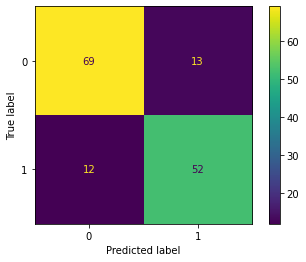

In [134]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [135]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8287671232876712
Precision: 0.8
Recall: 0.8125


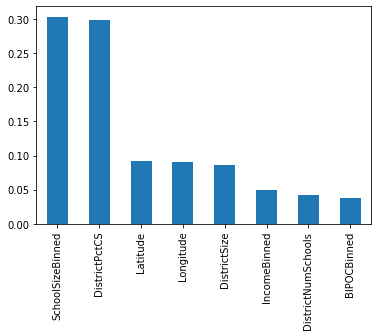

In [136]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

At first glance it appears that DistrictPctCS (percentage of district that offers CS) and size_binned (size of school) are the features with the most importance. 

Best hyperparameters: {'max_depth': 7, 'n_estimators': 70}


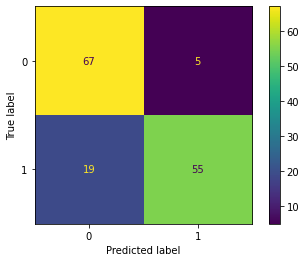

In [137]:
X = df_for_tree_v2.drop(['CS_Offered'], axis = 1)
y = df_for_tree_v2['CS_Offered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [138]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8356164383561644
Precision: 0.9166666666666666
Recall: 0.7432432432432432


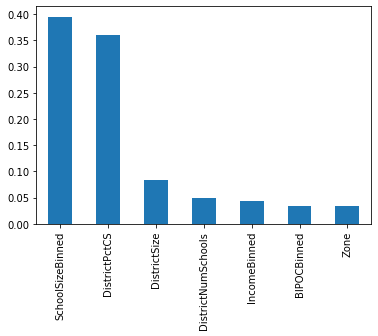

In [139]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

The Zone feature does appear to increase accuracy and precision but doesn't positively affect recall and lowers the importance of the location feature. The Zone feature may prove more useful in other models.

## Analysis: Logistic Regression

## Analysis: Mutual Information

## Analysis: Ensemble Learning
TODO: Re-run after feature encoding above  
This is a very basic first run at ensemble learning...will improve

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
warnings.filterwarnings('ignore')

# SPLITTING THE DATASET
df = reduced_ospi
x = df.drop(['CS_Offered', 'SchoolName', 'County'], axis = 1)
y = df['CS_Offered']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# MODELS CREATION
model1 = RandomForestClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(x_train,y_train)
model2.fit(x_train,y_train)
model3.fit(x_train,y_train)

# PREDICTION
pred1=model1.predict(x_test)
pred2=model2.predict(x_test)
pred3=model3.predict(x_test)

# FINAL_PREDICTION
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))
print(final_pred)

[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0.]
